In [ ]:
import os, re

BASE = "/Users/tanmayagarwal/Desktop/My_Computer/Columbia/Fall_2025/RA_LLM/main_folder"

FOLDERS = {
    "physics_chapters":   f"{BASE}/physics_chapters",
    "physics_pages":      f"{BASE}/physics_pages",
    "chemistry_chapters": f"{BASE}/chemistry_chapters",
    "chemistry_pages":    f"{BASE}/chemistry_pages",
    "biology_chapters":   f"{BASE}/biology_chapters",
    "biology_pages":      f"{BASE}/biology_pages",
}

FORMULA_RE = re.compile(r"\$\$(.*?)\$\$", flags=re.DOTALL)

def strip_formulas(text: str) -> str:
    return FORMULA_RE.sub(" ", text)

documents = {}
for label, folder in FOLDERS.items():
    if not os.path.isdir(folder):
        print(f"[WARN] Missing folder: {folder}")
        continue
    for fname in sorted(os.listdir(folder)):
        if fname.endswith(".md"):
            path = os.path.join(folder, fname)
            with open(path, "r", encoding="utf-8", errors="ignore") as f:
                raw = f.read()
            documents[f"{label}/{fname}"] = strip_formulas(raw).lower()

print(f"Loaded {len(documents)} files.")
list(documents.keys())[:5]


Loaded 4510 files.


['physics_chapters/chapter_00_introduction.md',
 'physics_chapters/chapter_01.md',
 'physics_chapters/chapter_02.md',
 'physics_chapters/chapter_03.md',
 'physics_chapters/chapter_04.md']

In [ ]:

import spacy
try:
    nlp = spacy.load("en_core_web_sm")
except Exception:
    nlp = spacy.blank("en")
    from spacy.lang.en.stop_words import STOP_WORDS
    nlp.Defaults.stop_words |= STOP_WORDS

nlp.max_length = max(getattr(nlp, "max_length", 1_000_000), 10_000_000)


In [ ]:
# this block is only for approximating how much time the code will run for.
"""
from time import perf_counter

sample_items = list(documents.items())[:20] if len(documents) > 20 else list(documents.items())
t0 = perf_counter()
for _, txt in sample_items:
    _ = nlp(txt)
t1 = perf_counter()
per_doc = (t1 - t0) / max(1, len(sample_items))
total_min = per_doc * len(documents) / 60
print(f"~{per_doc:.3f}s per doc  →  est. {total_min:.1f} min for all")
"""

~2.741s per doc  →  est. 206.0 min for all


In [ ]:
from collections import Counter
from tqdm.auto import tqdm  

stats = {}
names = list(documents.keys())
texts = [documents[n] for n in names]

DISABLE = ["tagger", "parser", "ner", "attribute_ruler", "lemmatizer"] 
BATCH = 100

for name, doc in tqdm(
    zip(names, nlp.pipe(texts, batch_size=BATCH, disable=DISABLE)),
    total=len(names), desc="Token stats", smoothing=0.1
):
    toks_all = [t.text for t in doc if not t.is_space]   
    toks_no_stop = [t.text for t in doc if t.is_alpha and not t.is_stop]

    stats[name] = {
        "total_tokens": len(toks_all),
        "unique_tokens": len(set(toks_all)),
        "total_no_stop": len(toks_no_stop),
        "unique_no_stop": len(set(toks_no_stop)),
    }
next(iter(stats.items()))


Token stats: 100%|██████████| 4510/4510 [02:55<00:00, 25.75it/s]


('physics_chapters/chapter_00_introduction.md',
 {'total_tokens': 6580,
  'unique_tokens': 2234,
  'total_no_stop': 3283,
  'unique_no_stop': 1370})

In [ ]:
# Builds a DTM (rows=docs, cols=terms) from content tokens; toggle lemmas for better matching across word forms.

import pandas as pd
from collections import Counter

USE_LEMMAS = False  # True → use t.lemma_ (requires lemmatizer); False → use t.text (faster)

DISABLE_DTM = ["tagger", "parser", "ner", "attribute_ruler", "lemmatizer"]

term_counts = {}
for name, doc in tqdm(
    zip(names, nlp.pipe(texts, batch_size=BATCH, disable=DISABLE_DTM)),
    total=len(names), desc=f"DTM ({'lemmas' if USE_LEMMAS else 'tokens'})", smoothing=0.1
):
    toks = [t.text   for t in doc if t.is_alpha and not t.is_stop]
    term_counts[name] = Counter(toks)

dtm = pd.DataFrame.from_dict(term_counts, orient="index").fillna(0).astype(int)
dtm = dtm.reindex(sorted(dtm.columns), axis=1).fillna(0).astype(int)

dtm.shape, dtm.iloc[:3, :8]

DTM (tokens): 100%|██████████| 4510/4510 [02:53<00:00, 25.97it/s]


((4435, 28877),
                                              aa  aaa  aabb  aabbcc  aacc  \
 physics_chapters/chapter_00_introduction.md   0    0     0       0     0   
 physics_chapters/chapter_31.md                0    0     0       0     0   
 physics_pages/page_0001.md                    0    0     0       0     0   
 
                                              aadem  aag  aand  
 physics_chapters/chapter_00_introduction.md      0    0     0  
 physics_chapters/chapter_31.md                   0    0     0  
 physics_pages/page_0001.md                       0    0     0  )

In [11]:
import os
out_dir = os.path.join(BASE, "_outputs"); os.makedirs(out_dir, exist_ok=True)

In [ ]:
import numpy as np

doc_names = list(dtm.index)
doc_sets = {d: set(term_counts[d].keys()) for d in doc_names}

n = len(doc_names)
jaccard = np.zeros((n, n), dtype=float)
for i in range(n):
    A = doc_sets[doc_names[i]]
    for j in range(n):
        B = doc_sets[doc_names[j]]
        jaccard[i, j] = 100.0 * len(A & B) / len(A | B) if (A or B) else 0.0

jaccard_df = pd.DataFrame(jaccard, index=doc_names, columns=doc_names)
jaccard_df.round(1).iloc[:8, :8]


,physics_chapters/chapter_00_introduction.md,physics_chapters/chapter_31.md,physics_pages/page_0001.md,physics_pages/page_0003.md,physics_pages/page_0005.md,physics_pages/page_0006.md,physics_pages/page_0019.md,physics_pages/page_0020.md
physics_chapters/chapter_00_introduction.md,100.0,15.4,0.2,1.1,11.2,8.4,18.2,19.9
physics_chapters/chapter_31.md,15.4,100.0,0.0,0.2,1.1,1.5,4.4,5.3
physics_pages/page_0001.md,0.2,0.0,100.0,5.9,0.6,0.9,0.4,0.4
physics_pages/page_0003.md,1.1,0.2,5.9,100.0,1.8,2.4,1.5,1.1
physics_pages/page_0005.md,11.2,1.1,0.6,1.8,100.0,2.7,9.2,4.4
physics_pages/page_0006.md,8.4,1.5,0.9,2.4,2.7,100.0,6.4,2.4
physics_pages/page_0019.md,18.2,4.4,0.4,1.5,9.2,6.4,100.0,11.1
physics_pages/page_0020.md,19.9,5.3,0.4,1.1,4.4,2.4,11.1,100.0


In [ ]:
"""
corr_df = dtm.T.corr(method="pearson") * 100.0
corr_df.round(1).iloc[:8, :8]
"""

#taking too much time so finding cosine similarity would be better, if still needed i will do in end

'\ncorr_df = dtm.T.corr(method="pearson") * 100.0\ncorr_df.round(1).iloc[:8, :8]\n'

In [ ]:

import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.auto import tqdm

docs_order = list(term_counts.keys())
corpus_for_tfidf = [" ".join([tok for tok, c in term_counts[name].items() for _ in range(c)])
                    for name in docs_order]

tfidf = TfidfVectorizer(lowercase=False, token_pattern=r"(?u)\b\w+\b")
X_tfidf = tfidf.fit_transform(corpus_for_tfidf)
n = X_tfidf.shape[0]
sim = np.zeros((n, n), dtype=np.float32)
tile = 500 

pbar = tqdm(total=n, desc="Cosine TF-IDF tiles")
start = 0
while start < n:
    end = min(start + tile, n)
    block = cosine_similarity(X_tfidf[start:end], X_tfidf)
    sim[start:end, :] = block.astype(np.float32) * 100.0
    start = end
    pbar.update(block.shape[0])
pbar.close()

cosine_df = pd.DataFrame(sim, index=docs_order, columns=docs_order)
cosine_df.iloc[:8, :8].round(1)


Cosine TF-IDF tiles: 100%|██████████| 4510/4510 [00:00<00:00, 10748.44it/s]


,physics_chapters/chapter_00_introduction.md,physics_chapters/chapter_01.md,physics_chapters/chapter_02.md,physics_chapters/chapter_03.md,physics_chapters/chapter_04.md,physics_chapters/chapter_05.md,physics_chapters/chapter_06.md,physics_chapters/chapter_07.md
physics_chapters/chapter_00_introduction.md,100.000000,23.600000,11.800000,11.100000,19.700001,12.800000,14.400000,16.299999
physics_chapters/chapter_01.md,23.600000,100.000000,25.200001,17.299999,24.799999,20.700001,25.200001,20.400000
physics_chapters/chapter_02.md,11.800000,25.200001,100.000000,54.299999,34.400002,30.799999,43.099998,25.500000
physics_chapters/chapter_03.md,11.100000,17.299999,54.299999,100.000000,29.500000,24.299999,29.799999,19.200001
physics_chapters/chapter_04.md,19.700001,24.799999,34.400002,29.500000,100.000000,56.000000,54.000000,38.599998
physics_chapters/chapter_05.md,12.800000,20.700001,30.799999,24.299999,56.000000,100.000000,40.700001,35.900002
physics_chapters/chapter_06.md,14.400000,25.200001,43.099998,29.799999,54.000000,40.700001,100.000000,28.799999
physics_chapters/chapter_07.md,16.299999,20.400000,25.500000,19.200001,38.599998,35.900002,28.799999,100.000000


In [ ]:
# Saves stats, DTM, and whichever similarity matrix you actually computed (corr_df or cosine_df).

import os
out_dir = os.path.join(BASE, "_outputs")
os.makedirs(out_dir, exist_ok=True)

pd.DataFrame.from_dict(stats, orient="index").to_csv(os.path.join(out_dir, "token_stats.csv"))
dtm.to_csv(os.path.join(out_dir, "dtm_counts.csv"))

saved_any_similarity = False
"""
# Prefer Pearson if available
if "corr_df" in globals():
    corr_df.to_csv(os.path.join(out_dir, "pearson_corr_percent.csv"))
    print("Saved Pearson correlation → pearson_corr_percent.csv")
    saved_any_similarity = True
"""

if not saved_any_similarity and "cosine_df" in globals():
    cosine_df.to_csv(os.path.join(out_dir, "cosine_tfidf_percent.csv"))
    print("Saved cosine TF-IDF similarity → cosine_tfidf_percent.csv")
    saved_any_similarity = True


if "jaccard_df" in globals():
    jaccard_df.to_csv(os.path.join(out_dir, "jaccard_overlap_percent.csv"))
    print("Saved Jaccard overlap → jaccard_overlap_percent.csv")

print("Saved to:", out_dir)


KeyboardInterrupt: 

Visualization

In [22]:
# Imports seaborn/matplotlib and defines a helper to plot & save big matrices nicely.

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_heatmap(df, title, out_name, vmin=None, vmax=None, cmap="viridis", annotate=False):
    plt.figure(figsize=(10, 8))  # grow if you need more resolution
    ax = sns.heatmap(
        df, vmin=vmin, vmax=vmax, cmap=cmap,
        square=True, cbar=True, xticklabels=False, yticklabels=False,
        annot=annotate, fmt=".1f"
    )
    ax.set_title(title)
    plt.tight_layout()

    out_dir = os.path.join(BASE, "_outputs")
    os.makedirs(out_dir, exist_ok=True)
    path = os.path.join(out_dir, out_name)
    plt.savefig(path, dpi=300)
    plt.show()
    print("Saved figure →", path)


In [23]:
# Reads the matrices you saved so plots are reproducible even in a fresh session.

out_dir = os.path.join(BASE, "_outputs")
jaccard_df = pd.read_csv(os.path.join(out_dir, "jaccard_overlap_percent.csv"), index_col=0)
cosine_df  = pd.read_csv(os.path.join(out_dir, "cosine_tfidf_percent.csv"), index_col=0)  # if you made cosine
print(jaccard_df.shape, cosine_df.shape)


(4435, 4435) (4510, 4510)


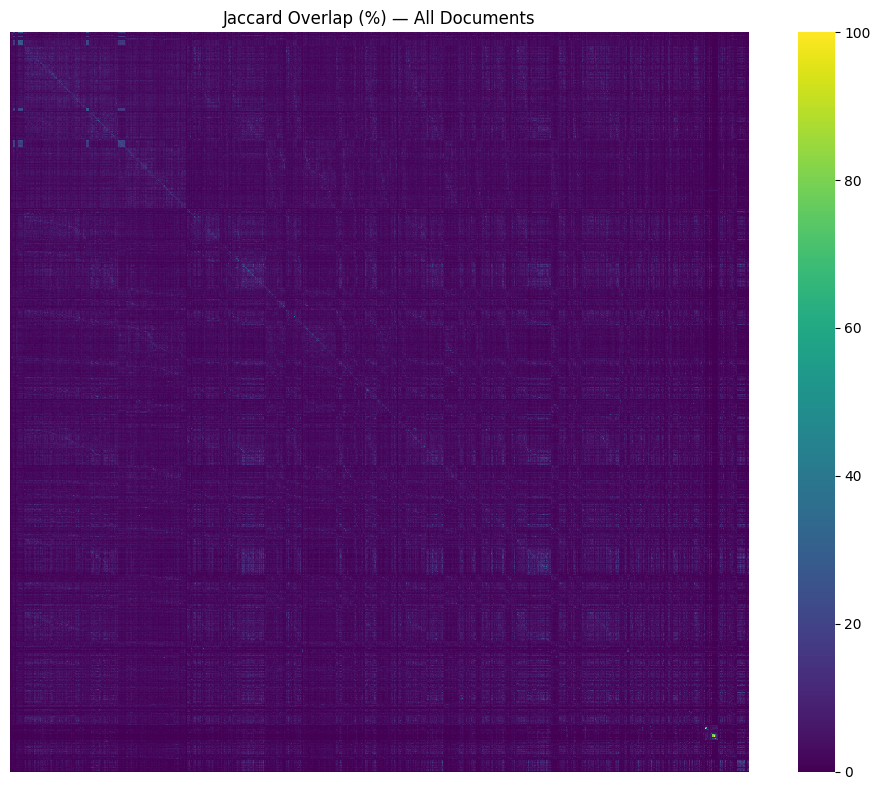

Saved figure → /Users/tanmayagarwal/Desktop/My_Computer/Columbia/Fall_2025/RA_LLM/main_folder/_outputs/heatmap_jaccard_all.png


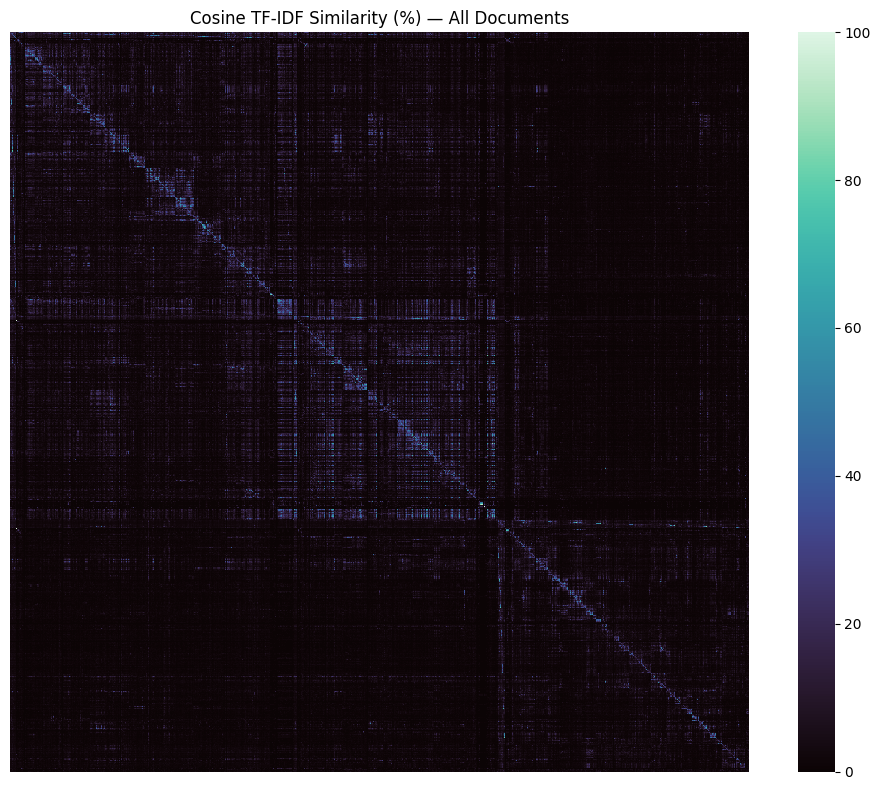

Saved figure → /Users/tanmayagarwal/Desktop/My_Computer/Columbia/Fall_2025/RA_LLM/main_folder/_outputs/heatmap_cosine_all.png


In [24]:
# Plots full heatmaps; for very large matrices, hide tick labels to keep rendering fast.

plot_heatmap(
    jaccard_df,
    title="Jaccard Overlap (%) — All Documents",
    out_name="heatmap_jaccard_all.png",
    vmin=0, vmax=100, cmap="viridis", annotate=False
)

plot_heatmap(
    cosine_df,
    title="Cosine TF-IDF Similarity (%) — All Documents",
    out_name="heatmap_cosine_all.png",
    vmin=0, vmax=100, cmap="mako", annotate=False
)


In [30]:
# Slices matrices by prefix to visualize specific groups (intrabook) or cross-groups (interbook).

def rows_with_prefix(df, prefix):
    return [i for i in df.index if i.startswith(prefix)]

phys_chap = rows_with_prefix(jaccard_df, "physics_chapters/")
bio_chap = rows_with_prefix(jaccard_df, "chemistry_chapters/")
chem_chap = rows_with_prefix(jaccard_df, "biology_chapters/")
phys_pages = rows_with_prefix(jaccard_df, "physics_pages/")
bio_pages = rows_with_prefix(jaccard_df, "biology_pages/")
chem_pages = rows_with_prefix(jaccard_df, "chemistry_pages/")



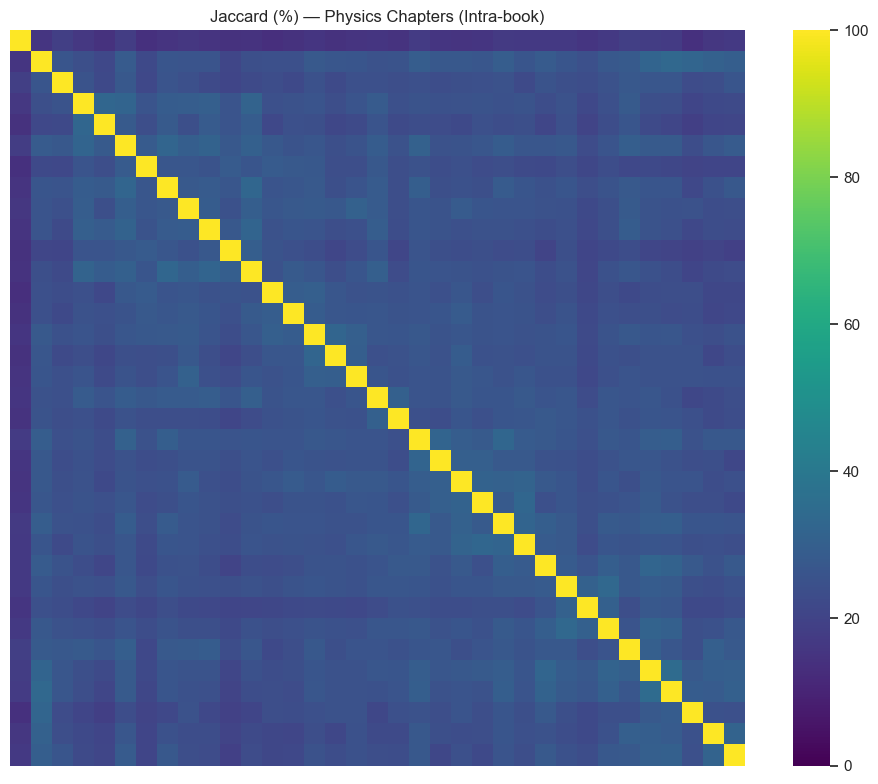

Saved figure → /Users/tanmayagarwal/Desktop/My_Computer/Columbia/Fall_2025/RA_LLM/main_folder/_outputs/heatmap_jaccard_physics_chapters.png


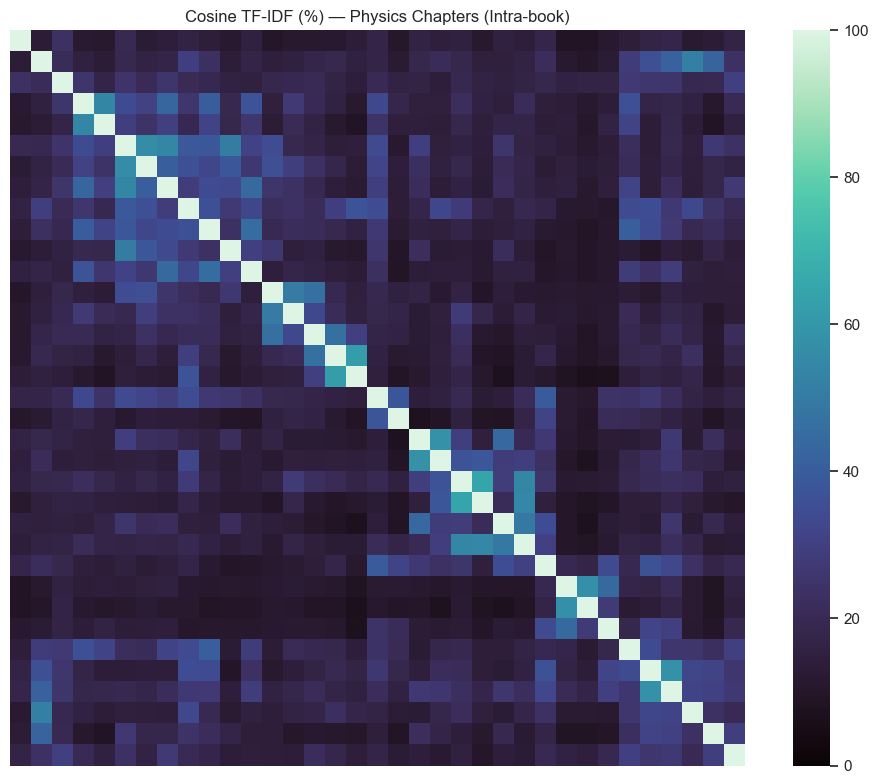

Saved figure → /Users/tanmayagarwal/Desktop/My_Computer/Columbia/Fall_2025/RA_LLM/main_folder/_outputs/heatmap_cosine_physics_chapters.png


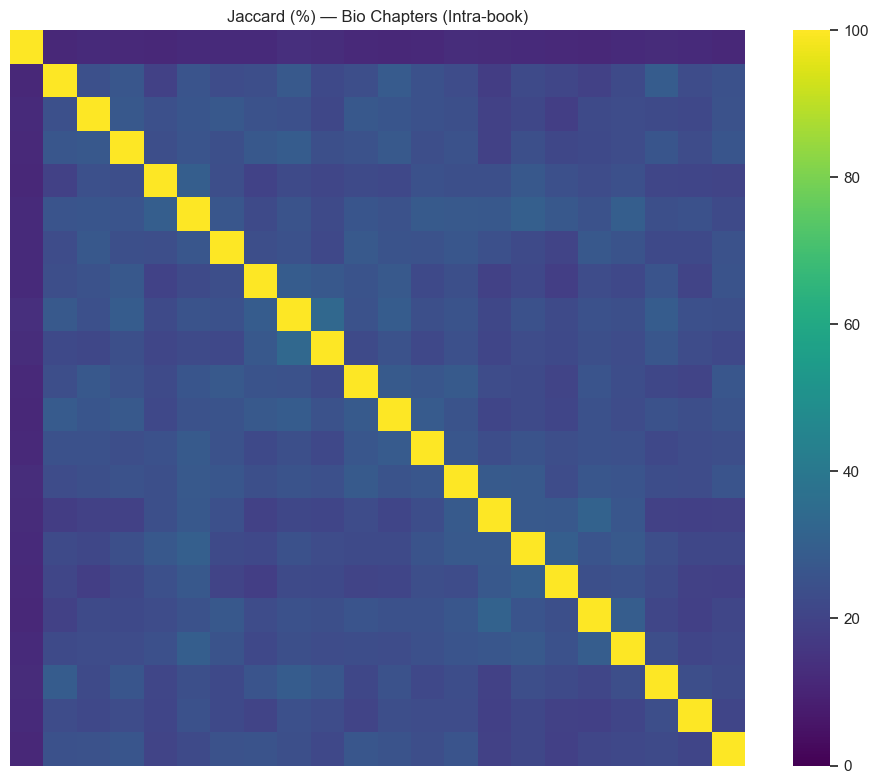

Saved figure → /Users/tanmayagarwal/Desktop/My_Computer/Columbia/Fall_2025/RA_LLM/main_folder/_outputs/heatmap_jaccard_biology_chapters.png


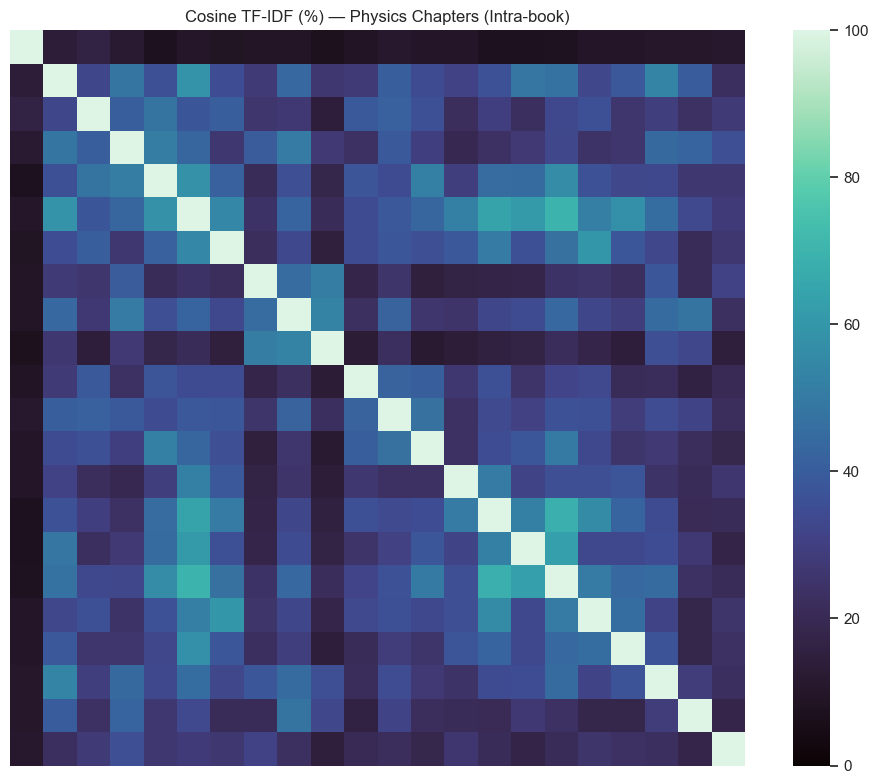

Saved figure → /Users/tanmayagarwal/Desktop/My_Computer/Columbia/Fall_2025/RA_LLM/main_folder/_outputs/heatmap_cosine_biology_chapters.png


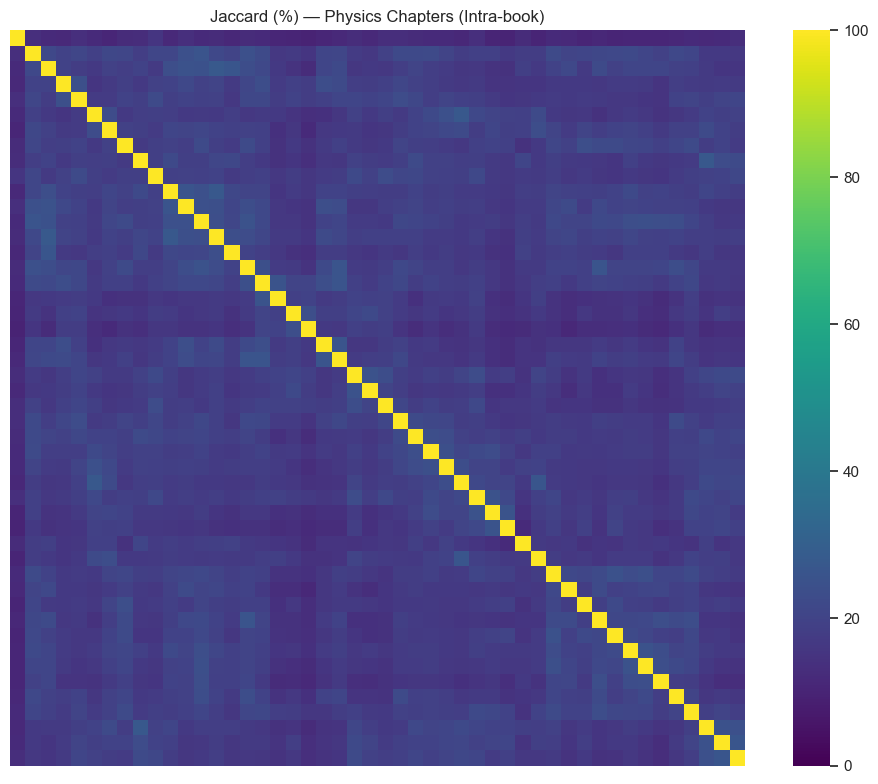

Saved figure → /Users/tanmayagarwal/Desktop/My_Computer/Columbia/Fall_2025/RA_LLM/main_folder/_outputs/heatmap_jaccard_chemistry_chapters.png


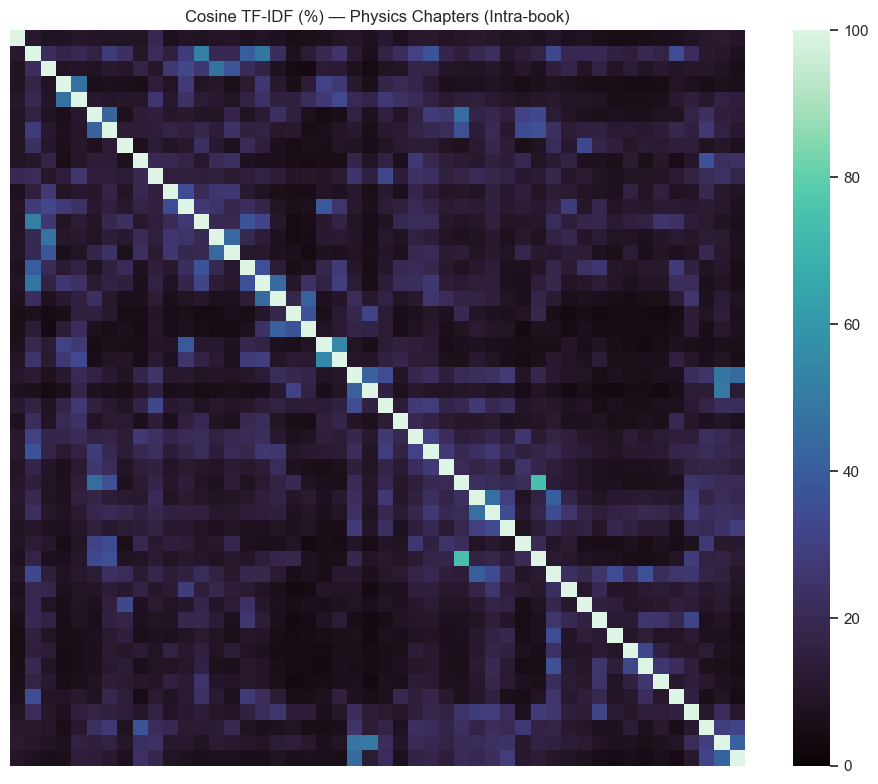

Saved figure → /Users/tanmayagarwal/Desktop/My_Computer/Columbia/Fall_2025/RA_LLM/main_folder/_outputs/heatmap_cosine_chemistry_chapters.png


In [38]:

# Intrabook: physics chapters only
plot_heatmap(
    jaccard_df.loc[phys_chap, phys_chap],
    title="Jaccard (%) — Physics Chapters (Intra-book)",
    out_name="heatmap_jaccard_physics_chapters.png",
    vmin=0, vmax=100, cmap="viridis"
)

plot_heatmap(
    cosine_df.loc[phys_chap, phys_chap],
    title="Cosine TF-IDF (%) — Physics Chapters (Intra-book)",
    out_name="heatmap_cosine_physics_chapters.png",
    vmin=0, vmax=100, cmap="mako"
)


# Intrabook: biology chapters only
plot_heatmap(
    jaccard_df.loc[bio_chap, bio_chap],
    title="Jaccard (%) — Bio Chapters (Intra-book)",
    out_name="heatmap_jaccard_biology_chapters.png",
    vmin=0, vmax=100, cmap="viridis"
)

plot_heatmap(
    cosine_df.loc[bio_chap, bio_chap],
    title="Cosine TF-IDF (%) — Physics Chapters (Intra-book)",
    out_name="heatmap_cosine_biology_chapters.png",
    vmin=0, vmax=100, cmap="mako"
)


# Intrabook: chemistry chapters only
plot_heatmap(
    jaccard_df.loc[chem_chap, chem_chap],
    title="Jaccard (%) — Physics Chapters (Intra-book)",
    out_name="heatmap_jaccard_chemistry_chapters.png",
    vmin=0, vmax=100, cmap="viridis"
)

plot_heatmap(
    cosine_df.loc[chem_chap, chem_chap],
    title="Cosine TF-IDF (%) — Physics Chapters (Intra-book)",
    out_name="heatmap_cosine_chemistry_chapters.png",
    vmin=0, vmax=100, cmap="mako"
)

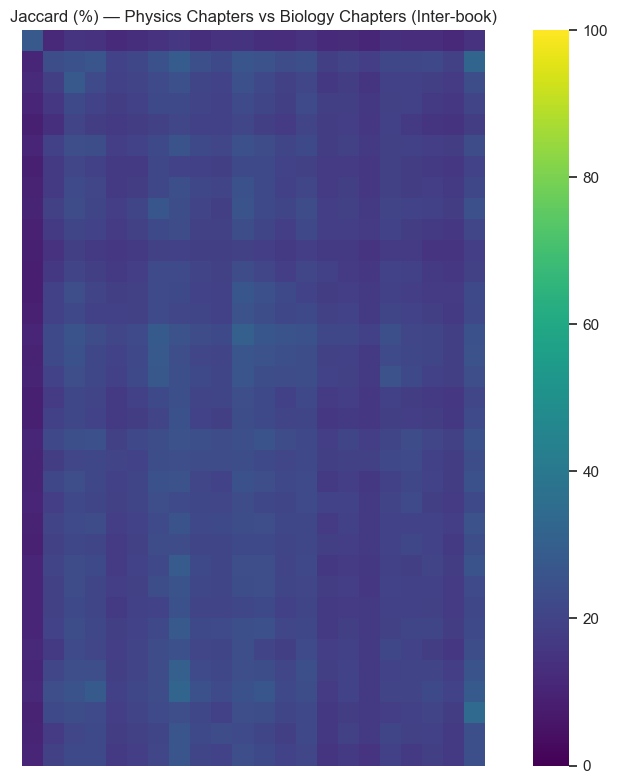

Saved figure → /Users/tanmayagarwal/Desktop/My_Computer/Columbia/Fall_2025/RA_LLM/main_folder/_outputs/heatmap_jaccard_physchap_vs_bio_chap.png


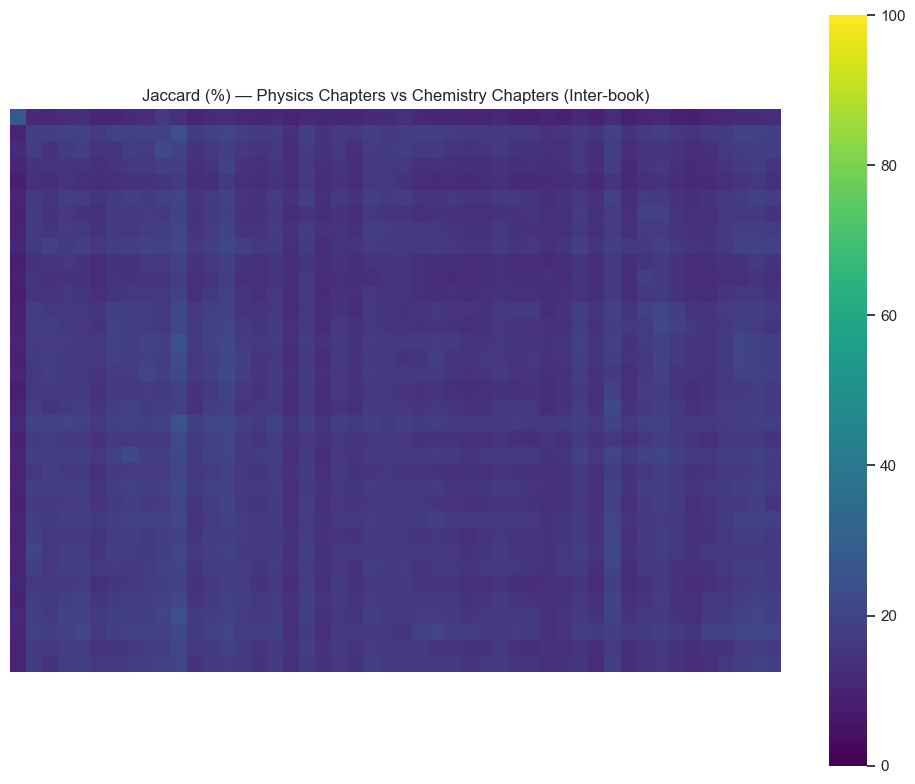

Saved figure → /Users/tanmayagarwal/Desktop/My_Computer/Columbia/Fall_2025/RA_LLM/main_folder/_outputs/heatmap_jaccard_physchap_vs_chem_chap.png


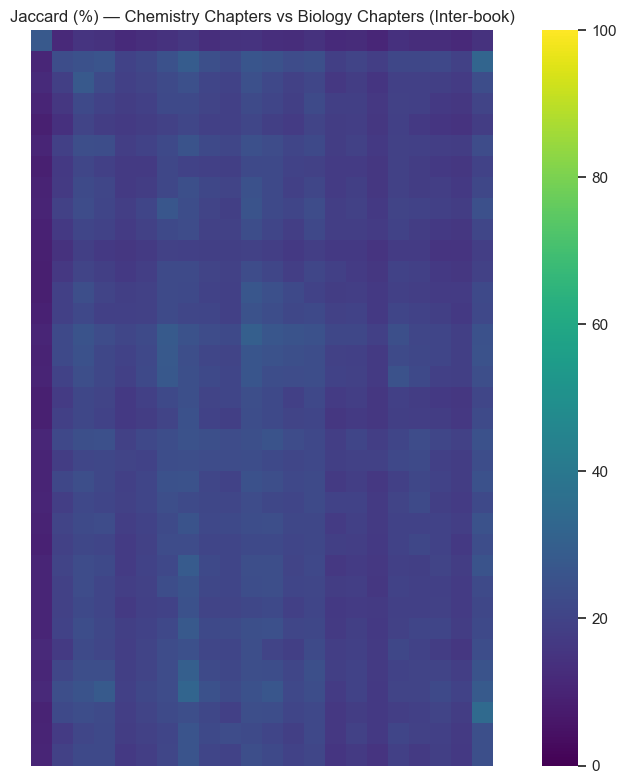

Saved figure → /Users/tanmayagarwal/Desktop/My_Computer/Columbia/Fall_2025/RA_LLM/main_folder/_outputs/heatmap_jaccard_chemchap_vs_bio_chap.png


In [36]:
# Interbook: physics chapters vs biology pages
plot_heatmap(
    jaccard_df.loc[phys_chap, bio_chap],
    title="Jaccard (%) — Physics Chapters vs Biology Chapters (Inter-book)",
    out_name="heatmap_jaccard_physchap_vs_bio_chap.png",
    vmin=0, vmax=100, cmap="viridis"
)

# Interbook: physics chapters vs biology pages
plot_heatmap(
    jaccard_df.loc[phys_chap, chem_chap],
    title="Jaccard (%) — Physics Chapters vs Chemistry Chapters (Inter-book)",
    out_name="heatmap_jaccard_physchap_vs_chem_chap.png",
    vmin=0, vmax=100, cmap="viridis"
)

# Interbook: physics chapters vs biology pages
plot_heatmap(
    jaccard_df.loc[phys_chap, bio_chap],
    title="Jaccard (%) — Chemistry Chapters vs Biology Chapters (Inter-book)",
    out_name="heatmap_jaccard_chemchap_vs_bio_chap.png",
    vmin=0, vmax=100, cmap="viridis"
)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


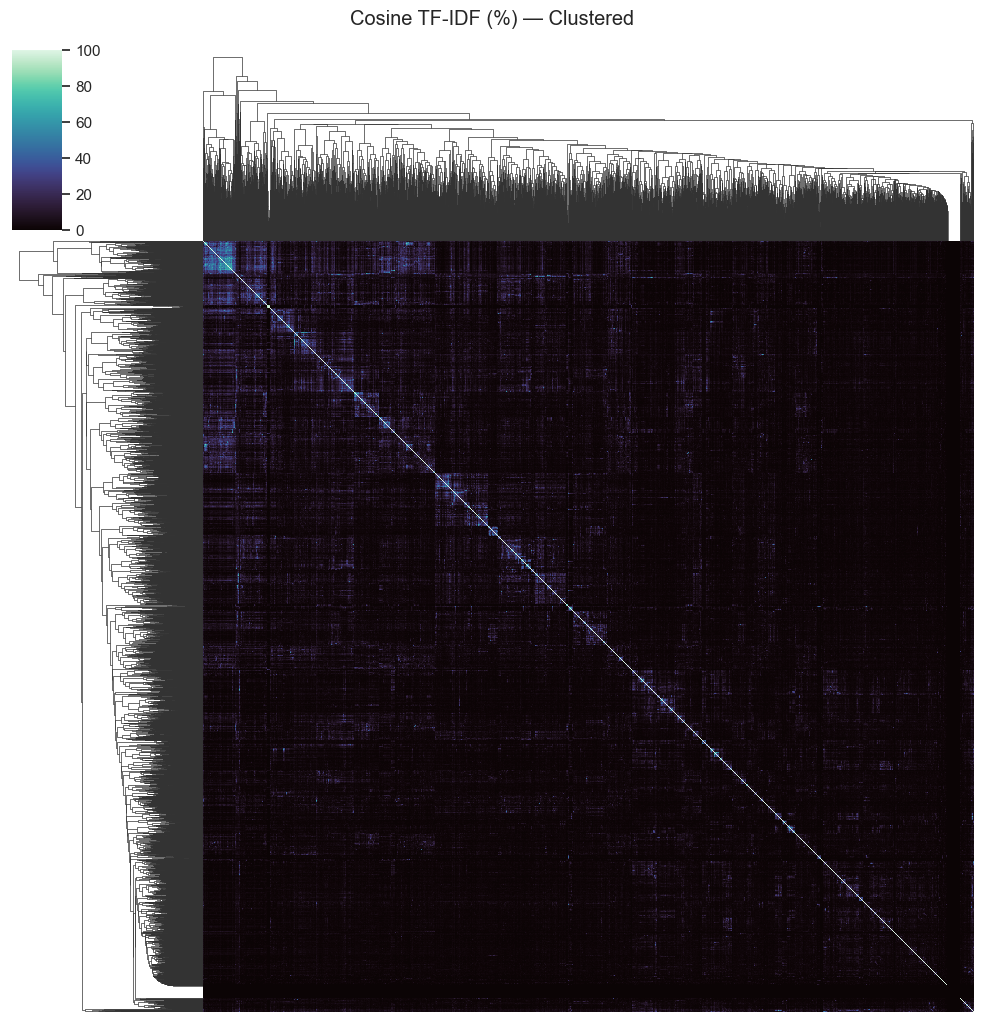

Saved figure → /Users/tanmayagarwal/Desktop/My_Computer/Columbia/Fall_2025/RA_LLM/main_folder/_outputs/clustermap_cosine_all.png


In [33]:

sns.set(context="notebook")
g = sns.clustermap(
    cosine_df, cmap="mako", figsize=(10, 10),
    row_cluster=True, col_cluster=True,
    xticklabels=False, yticklabels=False
)
g.fig.suptitle("Cosine TF-IDF (%) — Clustered", y=1.02)
out_path = os.path.join(BASE, "_outputs", "clustermap_cosine_all.png")
g.savefig(out_path, dpi=300)
plt.show()
print("Saved figure →", out_path)


In [37]:

def top_k_neighbors(sim_df, k=5):
    rows = []
    for i, row in sim_df.iterrows():
        # drop self-similarity then take top-k
        sr = row.drop(labels=[i], errors="ignore").sort_values(ascending=False).head(k)
        for j, val in sr.items():
            rows.append({"doc": i, "neighbor": j, "score_percent": round(float(val), 2)})
    return pd.DataFrame(rows)

nn_cosine = top_k_neighbors(cosine_df, k=5)
nn_jaccard = top_k_neighbors(jaccard_df, k=5)

nn_cosine.head(10)
nn_cosine.tail(10)


,doc,neighbor,score_percent
22540,biology_pages/page_1486.md,biology_pages/page_0458.md,15.57
22541,biology_pages/page_1486.md,biology_pages/page_0443.md,15.50
22542,biology_pages/page_1486.md,biology_chapters/chapter_16.md,15.21
22543,biology_pages/page_1486.md,biology_pages/page_0457.md,12.97
22544,biology_pages/page_1486.md,biology_pages/page_1336.md,12.09
22545,biology_pages/page_1487.md,biology_pages/page_0711.md,15.76
22546,biology_pages/page_1487.md,biology_pages/page_0720.md,15.35
22547,biology_pages/page_1487.md,biology_pages/page_0719.md,14.90
22548,biology_pages/page_1487.md,biology_pages/page_0893.md,14.75
22549,biology_pages/page_1487.md,biology_pages/page_0889.md,14.00


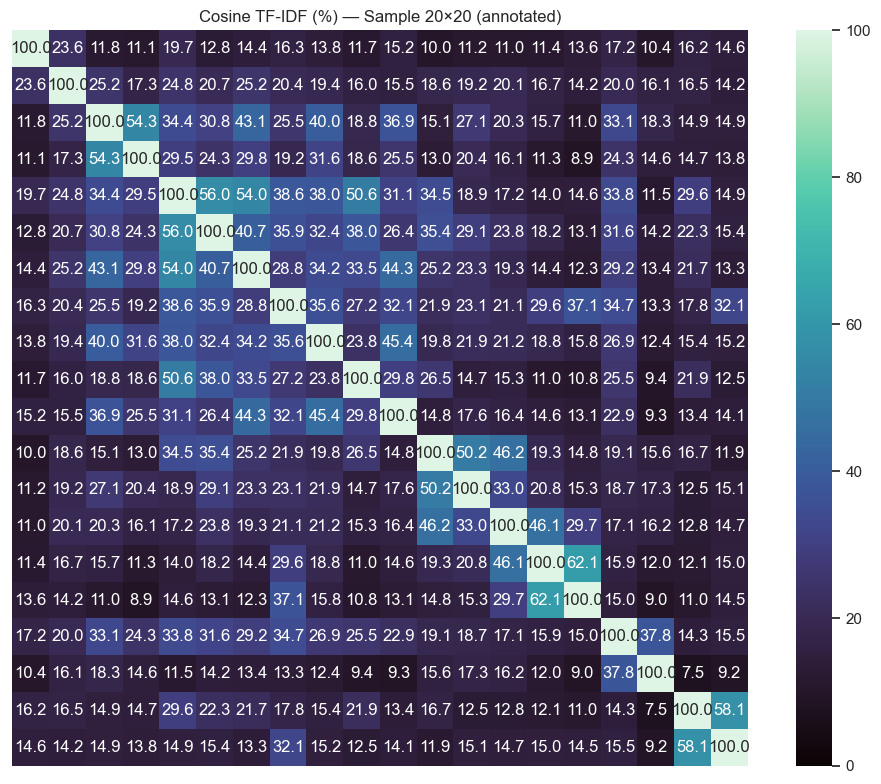

Saved figure → /Users/tanmayagarwal/Desktop/My_Computer/Columbia/Fall_2025/RA_LLM/main_folder/_outputs/heatmap_cosine_sample_annot.png


In [35]:
# For small subsets (e.g., 20x20).

subset = cosine_df.iloc[:20, :20]
plot_heatmap(
    subset,
    title="Cosine TF-IDF (%) — Sample 20×20 (annotated)",
    out_name="heatmap_cosine_sample_annot.png",
    vmin=0, vmax=100, cmap="mako", annotate=True
)
